(3site-cycle-nb)=
# 1D cycle of 1D tight-binding model

In [4]:
from pythtb import TBModel, WFArray, Mesh
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# define lattice vectors
lat = [[1]]
# define coordinates of orbitals
orb = [[0], [1 / 3], [2 / 3]]

# make one dimensional tight-binding model
my_model = TBModel(1, 1, lat, orb)

# set model parameters
delta = 2.0
t = -1.0

# set hoppings (one for each connected pair of orbitals)
# (amplitude, i, j, [lattice vector to cell containing j])
my_model.set_hop(t, 0, 1, [0])
my_model.set_hop(t, 1, 2, [0])
my_model.set_hop(t, 2, 0, [1])

Evolve tight-binding parameters along some path by performing a change of onsite terms

In [9]:
#  steps to take along the path (including end points)
path_steps = 21
#  create lambda mesh from 0 to 1 (21 values and 20 intervals)
all_lambda = np.linspace(0, 1, path_steps, endpoint=True)

#  number of k-points to use (31 values and 30 intervals)
num_kpt = 31
# create k mesh over 1D Brillouin zone
(k_vec, k_dist, k_node) = my_model.k_path([[-0.5], [0.5]], num_kpt, report=False)

Two-dimensional `WFArray` in which we will store wavefunctions for all k-points and all values of $\lambda$.  

:::{note}
The index order `[k,lambda]` is important for interpreting the sign.
:::

In [7]:
mesh = Mesh(my_model)
mesh.build_grid(shape_k=(num_kpt,), shape_param=(path_steps,), gamma_centered=True, full_grid=True)
wf_kpt_lambda = WFArray(my_model, mesh)

Populate the `WFArray` with wavefunctions for all k-points and all values of $\lambda$.

In [21]:


eval_lam = []
for i_lambda in range(path_steps):
    # for each step along the path compute onsite terms for each orbital
    lmbd = all_lambda[i_lambda]
    onsite_0 = delta * -np.cos(2 * np.pi * (lmbd - 0 / 3))
    onsite_1 = delta * -np.cos(2 * np.pi * (lmbd - 1 / 3))
    onsite_2 = delta * -np.cos(2 * np.pi * (lmbd - 2 / 3))

    # update onsite terms by rewriting previous values
    my_model.set_onsite([onsite_0, onsite_1, onsite_2], mode="set")

    # solve model on all of these k-points
    eval, evec = my_model.solve_ham(k_vec, return_eigvecs=True)

    # store wavefunctions (eigenvectors)
    for i_kpt in range(num_kpt):
        wf_kpt_lambda[i_kpt, i_lambda] = evec[i_kpt]

    eval_lam.append(eval)

Impose periodic boundary conditions along k-space direction only so that $|\psi_{n,k}\rangle$ at $k=0$ and $k=1$ have the same phase.

In [12]:
wf_kpt_lambda.impose_pbc(0, 0)

Compute Berry phase along k-direction for each $\lambda$

In [15]:
phase = wf_kpt_lambda.berry_phase([0], 0)

Wannier center in reduced coordinates

In [16]:
wann_center = phase / (2*np.pi)

Chern number of bottom band

In [18]:
chern = wf_kpt_lambda.chern_num(state_idx=[0], plane=(0,1))
print("Chern number in k-lambda space: ", chern)

Chern number in k-lambda space:  -1.0


Plot the position of Wannier function for bottom band

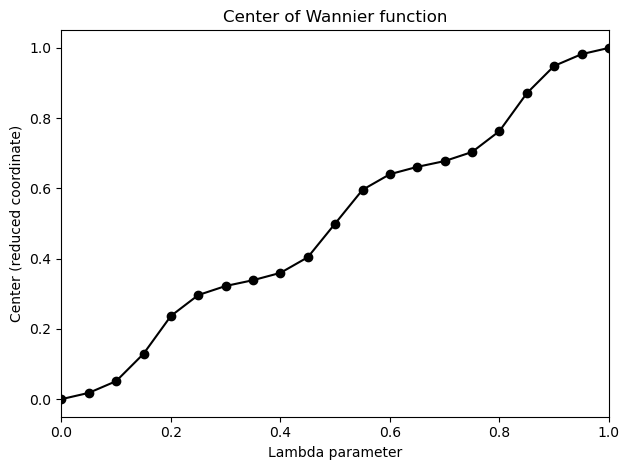

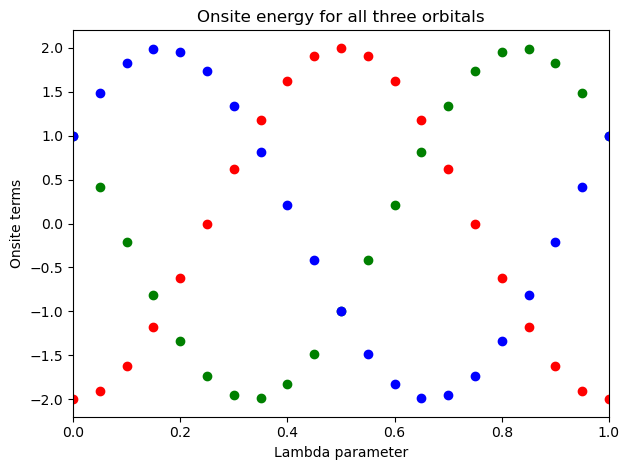

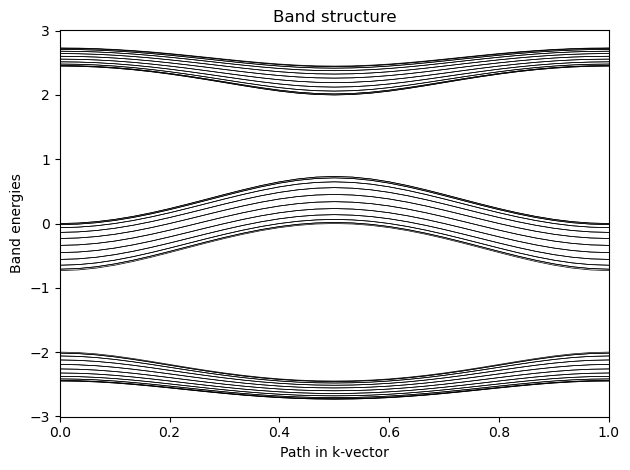

Done.



In [ ]:
fig_onsite, ax_onsite = plt.subplots()
fig_band, ax_band = plt.subplots()
fig_wann, ax_wann = plt.subplots()

# plot on-site terms
ax_onsite.scatter(all_lambda, delta * -np.cos(2 * np.pi * (all_lambda - 0 / 3)), c="r")
ax_onsite.scatter(all_lambda, delta * -np.cos(2 * np.pi * (all_lambda - 1 / 3)), c="g")
ax_onsite.scatter(all_lambda, delta * -np.cos(2 * np.pi * (all_lambda - 2 / 3)), c="b")

for i_lambda in range(path_steps):
    # plot band structure for all three bands
    ax_band.plot(k_dist, eval_lam[i_lambda], "k-", linewidth=0.5)

# Wannier centers
ax_wann.plot(all_lambda, wann_center, "ko-")

# finish plot of onsite terms
ax_onsite.set_title("Onsite energy for all three orbitals")
ax_onsite.set_xlabel("Lambda parameter")
ax_onsite.set_ylabel("Onsite terms")
ax_onsite.set_xlim(0, 1)

# finish plot for band structure
ax_band.set_title("Band structure")
ax_band.set_xlabel("Path in k-vector")
ax_band.set_ylabel("Band energies")
ax_band.set_xlim(0, 1)

# finish plot for Wannier center
ax_wann.set_title("Center of Wannier function")
ax_wann.set_xlabel("Lambda parameter")
ax_wann.set_ylabel("Center (reduced coordinate)")
ax_wann.set_xlim(0, 1)
